# How to Write Memory Efficient Loops in Python

A visual guide to generators and three ways to implement them

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "fantasy"
plt.rcParams["axes.linewidth"] = 1.5

## Intro

In python, when you build a list of numbers, images, files, or any other object that you want to iterate through, you're essentially piling up memory as you put new items on the list, i.e. every time you do `your_list.append(new_item)` your list consumes a chunk of memory equal to `sys.getsizeof(new_item)`. The problem here is that if your list is too long or your items are too large (or a combination of the two) you might end up using too much memory or even run out of it. 

However, in most situations when you iterate through a list you only need to have access to the items one at a time and not everything all at once. An example that I run into a lot in my line of work is stacking images: Let's say I have about 500 2D images each with 1000 pixels on the side and I want to stack all of them together and take an average (replace this with your favorite memory consuming example, e.g. loading these images from file to train you awesome CNN model). 

One way to approach the stacking problem would be to build a list of all the images and then take the average! 
Very simple but not memory efficient. Putting 500 images with (1000 x 1000) `np.float64` pixels takes about 4 GB of memory,  which at first sight is not that big a deal. But what if you had 5000 images instead? Can you afford using 40 GB of RAM for a simple stacking exercise? How about 50,000 images? You get the idea...

Here's what iterating through a list looks like: 
<img src="list.png" height="100"/>

When you think about it, in order to stack and average 500 images you don't need to have access to all the items at once. Since at the end you only care about the aggregated value of each pixel, you can build a (1000 x 1000) pixel image and use it as a stack, then go through the list like this: pick the first item, add it to the stack, throw the item away, then pick the second item, add it to the stack, throw it away, and so on...

<img src="gen.png" height="100"/>

Since you're always only keeping the pixels values of the stack and the new item in memory, RAM consumption is equal to two images at a time instead of having the whole array sitting there in memory. This is exactly what a generator does! You can clearly see why this second approach uses less memory compared to the first one. Now let's see how to implement this in action.  

## List Comprehension vs Generator Expression

First, I'm going to write a function that goes through an iterable (e.g. a list) containing 2D images with `n_pixels` and stacks all the elements together. My plan is to use this function with both a list and a generator, then compare the memory consumption as a function of time. Also, in order to make the contents easily reproducible instead of using actual images I'm just going to generate 2D matrices of random numbers. 

In [2]:
def stack_images(iterable, n_pixels):
    """stack the images in the iterable on a (n_pixel x n_pixel) canvas"""
    
    canvas = np.zeros((n_pixels,n_pixels))
    
    for item in iterable:
        canvas += item
        
    return canvas

def get_random_image(n_pixels):
    """create a random 2D image with n_pixels on the side"""
    
    return np.random.rand(n_pixels, n_pixels)

Let's use a list comprehension to create our iterable. If you're not familiar with list comprehensions check out this fantastic [guide by Real Python](https://realpython.com/list-comprehension-python/). 

In [3]:
def stack_using_list(n_images, n_pixels):
    """iterate through a list and stack the objects"""
    
    iterable = [get_random_image(n_pixels) for _ in range(n_images)]
    stack_images(iterable, n_pixels)
    
    # not returning anything because I only care about the memory consumption in creating the iterable


Now let's rewrite the same function this time using a generator. I wrote the previous function using a list comprehension instead of an explicit for loop because converting list comprehensions to a generator (or what we call a generator expression) is as easy as changing the square brackets `[...]` to parentheses `(...)`! 

In [4]:
def stack_using_generator(n_images, n_pixels):
    """iterate through a generator and stack the objects"""
    
    # notice the parentheses instead of square brackets in the next line 
    iterable = (get_random_image(n_pixels) for _ in range(n_images))
    stack_images(iterable, n_pixels)
    
    # not returning anything because I only care about the memory consumption in creating the iterable
    

You can barely even see the difference between the two functions but one uses way less memory than the other. Let's confirm this using the `memory_profiler` package. 

In [5]:
# let's stack 500 2D images with a 1000 pixels on the side 
n_images = 500
n_pixels = 1000

# and let's take snapshots of memory usage every 0.2 seconds
snapshot_interval = 0.2 # seconds

# if you don't have memory_profiler you can install it using pip 
from memory_profiler import profile, memory_usage

list_mem_usage = memory_usage((stack_using_list,(n_images, n_pixels)), interval=snapshot_interval)
gen_mem_usage = memory_usage((stack_using_generator,(n_images, n_pixels)), interval=snapshot_interval)

In [6]:
# define the time arrays for the x axis
list_time = np.arange(len(list_mem_usage)) * snapshot_interval
gen_time = np.arange(len(gen_mem_usage)) * snapshot_interval

And *Voila*!
As you can clearly see memory usage grows linearly as we build the list of images, but remains constant when using generators. And here we get the extra bonus that the generator method runs faster, although that's not always the case. 

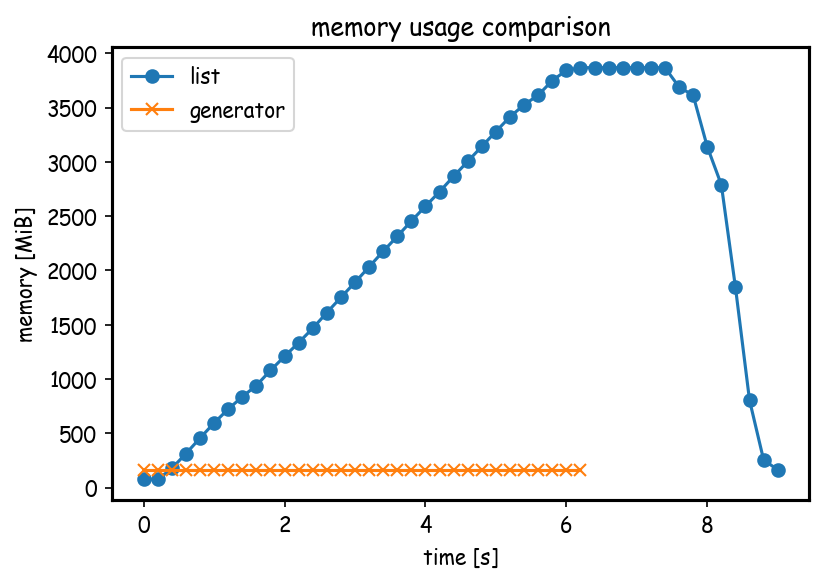

In [12]:
plt.figure(dpi=150)
plt.plot(list_time, list_mem_usage, '-o', label="list" )
plt.plot(gen_time, gen_mem_usage, '-x', label="generator")


plt.title("memory usage comparison")
plt.xlabel("time [s]")
plt.ylabel("memory [MiB]")
plt.legend()

#plt.savefig("list_vs_gen.png", dpi=150, bbox_inches="tight")

Creating generators using generator expressions can feel a bit limiting at times so now I will briefly describe two other methods for defining generators in python. 

## For Loops: Return vs Yield

Another way to create generators is to use the famous `yield` statement. Before we see how yield works, let's rewrite the list comprehension as an explicit for loop so that we can draw a parallel again:

In [7]:
def list_iterable(n_images, n_pixels):
    """return a list of n_images number of 2D images with n_pixels on the side"""
    
    # this is the same as the list comprehension in the use_list function:
    iterable = []
    for _ in range(n_images):
        iterable.append(get_image(n_pixels))
    
    return iterable

In order to write this for loop as a generator, instead of appending the items to the list and returning the whole list, you can just yield the items at hand, in this case a random 2D image, one at a time. The following is the equivalent of the previous generator expression but written more expressively. 

In [8]:
def gen_iterable(n_images, n_pixels):
    """return a generator of n_images number of 2D images with n_pixels on the side"""
    
    # some initialization code can go here
    # this is why you might prefer a generator function to a generator expression
    # e.g. you might need to start a counter or print a statement...
    
    print("starting the generator function...")

    for _ in range(n_images):
        yield get_random_image(n_pixels)
        
    # and you can add some final steps here e.g.
    print("Done!")

This function is now the equivalent of your generator expression that you used as an iterable in the `stack_using_gen` function and it does the exact same thing but as you can see it's more customizable.  

In [9]:
# let's test drive this real quick!
def stack_using_yield(n_images, n_pixels):
    """iterate through a generator and stack the objects"""
    
    iterable = gen_iterable(n_images, n_pixels)
    stack_images(iterable, n_pixels)
    

In [10]:
yield_mem_usage = memory_usage((stack_using_yield,(n_images, n_pixels)), interval=snapshot_interval)

starting the generator funtion...
Done!


## Generator Class

There is yet another way to write generators in python which I personally don't use often but am going to mention for the sake of completeness. If you need an even more customizable generator than the two previous methods you might want to use this one. 

In [11]:
class InfiniteGenerator:
    """Equivalent to 
    
    While True: 
        yield get_random_image(n_pixels) 
    """
    
    def __init__(self, n_pixels):        
        self.n_pixels = n_pixels

    def __iter__(self):
        """turn the class into an iterable so it can be used in a for loop"""
        
        return self
    
    def __next__(self):
        """call get_image in the next step of the iteration"""
        
        return get_random_image(self.n_pixels)

This guy right here is an infinite generator. You can initialize this similar to the gen_iterable function or use it in a for loop directly. If you iterate through `InfiniteGenerator()` it's just going to generate random 2D images forever (don't do it!). It's easy to implement extra conditions to customize this generator to your liking. Here's the standard way of setting a limit to the number of items the class is going to generate:

In [14]:
class LimitedGenerator:
        
    def __init__(self, n_images, n_pixels):
        """set limits for the iteration steps"""
        
        self.n_pixels = n_pixels
        
        # set a limit and start a counter
        self.limit = n_images
        self.counter = 0    
    
    def __iter__(self):
        """turn the class into an iterable so it can be used in a for loop"""
        
        return self
    
    def __next__(self):
        """generate the next item if limit hasn't been reached"""
        
        # Stop when counter reaches the limit
        if self.counter < self.limit:
            self.counter+=1
            return np.random.rand(self.n_pixels, self.n_pixels)
        else:
            raise StopIteration
            
# example usage 
generator = LimitedGenerator(n_images, n_pixels)

canvas = np.zeros_like(get_random_image(n_pixels))
for item in generator:

    canvas += item

But clearly we could do a lot more here! I could make the counter jump over odd numbers, or make the generator stop halfway through n_images, or make it restart after the counter is exhausted... The possibilities are endless much like generators so get creative!


And for those who love lists:
  
**Pros and Cons of Generators**

*Pros*
- They can be used to make infinite lists
- They are memory-efficient
- They can be customized to one's heart content

*Cons*
- Once you use an item it's gone forever
- You don't know how long they are until you reach the last item
- can be only traversed serially (you can't jump from item 1 to 5 and back to 3)


Check out the [python wiki](https://wiki.python.org/moin/Generators) for more details on generators. 